*Mapping the network*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point
# import copy

Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.


## Load data 
Data comes from http://stat-computing.org/dataexpo/2009/. 
Flight data relates to the year 2007 (see file Data_compiling) 

In [2]:
# Load airports data
Airports = pd.read_pickle("Airports.pkl").reset_index(drop=True)
Airports.tail(2)

,Airport_id,Name,City,Country,3DigitId,Lat,Lon,Altitude_ft
1510,13759,Oswego County Airport,Fulton,United States,\N,43.350800,-76.388100,475
1511,13803,Mitchell Municipal Airport,Mitchell,United States,MHE,43.774799,-98.038597,1304


In [3]:
# Load flights data
FlightsNx07 = pd.read_pickle("FlightsNx.pkl")
FlightsNx07.tail(2)

,Origin,Dest,Distance,count,Origin_flights,Destination_flights,origin_degree,origin_degree_unn,dest_degree,dest_degree_unn
5340,PIR,JAX,1395,2,8,71860.0,0.006472,2.0,0.126214,39.0
5341,ANC,HNL,2777,23,39504,135193.0,0.097087,30.0,0.080906,25.0


In [4]:
# Load flights data
FlightsNx18 = pd.read_pickle("FlightsNx18.pkl")
FlightsNx18.tail(2)

,Origin,Dest,Distance,count,avg_time_mins,companies,Origin_flights,Destination_flights,origin_degree,dest_degree,origin_btwns,dest_btwns,origin_clustcoef,dest_clustcoef
6423,DFW,BUF,1212.0,13,157.666667,1,573790,58407,170.0,27.0,0.156693,0.000024,0.142360,0.923077
6424,BUF,DFW,1212.0,12,219.454545,1,58407,573790,27.0,170.0,0.000024,0.156693,0.923077,0.142360


## Implement as network. 
For function documentation, see:  
https://networkx.github.io/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html?highlight=from_pandas_edgelist#networkx.convert_matrix.from_pandas_edgelist

In [16]:
class US_graph(object):
    ''' Creates a map network of flights for the US.
    '''

    def __init__(self, flights, airports=Airports, scalar=3, alpha=0.9):
        """ Read the data and create the network
            Optional: Set size-scalar and alpha for the nodes.
        """
        self.f = flights # Dataset on flights
        self.air = airports
        self.s = scalar # scalar for the size of the nodes
        self.a = alpha
        self.G = nx.from_pandas_edgelist(self.f, source = "Origin", target = "Dest", edge_attr = True)
        print(nx.info(self.G))

    def setup(self):
        """ Setup nodes, attributes and positions for drawing
        """ 
        # Get list of nodes, and add lat, lon from Airports dataset:
        nodes = pd.DataFrame(list(self.G.nodes()))
        nodes.columns = ["3DigitId"]
        positions = nodes.merge(self.air[["3DigitId","Lat","Lon"]], how = "left", on = "3DigitId")

        # Create a positions dictionary, which is in the format necessary to add it as a node attribute.
        pos_= dict()
        for idx, row in positions.iterrows():
            pos_[row['3DigitId']] = dict(pos=(row['Lat'], row['Lon']))

        # Set the node attributes. 
        nx.set_node_attributes(self.G, pos_)
        attributes = positions.merge(self.f[["Origin","Origin_flights","origin_degree_unn"]], how = "left", left_on = "3DigitId", right_on = "Origin").drop_duplicates()
        attributes = attributes.sort_values(by = "origin_degree_unn", ascending = False)

        # Positions for drawing
        pos = {city:(long, lat) for (city, (lat,long)) in nx.get_node_attributes(self.G, 'pos').items()}

        return nodes, attributes, pos

    def hubs(self):
        """ Setup hubs and position dictionary for labels
        """ 
        nodes, attributes, pos = self.setup()
        # Split airports according to size/importance for plotting purposes:
        airports = list(attributes.loc[attributes["origin_degree_unn"]<=25]["Origin"])
        hubs_small = list(attributes.loc[attributes["origin_degree_unn"]>25]["Origin"])
        hubs = list(attributes.loc[attributes["origin_degree_unn"]>50]["Origin"])
        hubs_large = list(attributes.loc[attributes["origin_degree_unn"]>100]["Origin"])

        # label location: how far above the center of the node
        raise_by = .8 + self.s*.1
        # Label large hubs for draw_networkx_labels
        pos_large = dict((k, (pos[k][0], pos[k][1]+raise_by)) for k in hubs_large if k in pos)
        return airports, hubs_small, hubs, hubs_large, pos_large
        
    def degree(self, subset):
        """ Function for degree size
            Returning size = degree*scalar for a given threshold
        """
        nodes, attributes, pos = self.setup()
        attributes['origin_degree_unn'].fillna(0, inplace=True)
        return [int(attributes.loc[attributes["3DigitId"]==i]['origin_degree_unn'])*self.s for i in subset]

    def draw(self, path):
        """ Draw the map with airports, small hubs, hubs, and large hubs
            The options are given by the __init__ above
        """
        nodes, attributes, pos = self.setup()
        airports, hubs_small, hubs, hubs_large, pos_large = self.hubs()
        
        # Get geographical file from GeoPandas
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        # Select US: 
        US = world[(world.pop_est>0) & (world.name == "United States")]

        fig, ax = plt.subplots(figsize = (16,12))
        ax.set_facecolor("lightblue")
        world.plot(ax = ax, color = "lightgrey", edgecolor = "black")
        US.plot(ax = ax, color = "whitesmoke", edgecolor = "black")
        plt.xlim(-126,-66)
        plt.ylim(24,50)
        nx.draw_networkx_edges(self.G, pos, width=0.05, with_labels=False, ax = ax)
        nx.draw_networkx_nodes(self.G, pos, nodelist = airports, alpha=self.a, node_size=self.degree(airports), node_color = "blue", with_labels=False, ax = ax).set_label("Airport")
        nx.draw_networkx_nodes(self.G, pos, nodelist = hubs_small, alpha=self.a, node_size=self.degree(hubs_small), node_color = "purple", with_labels=False, ax = ax).set_label("Small hub, degree > 25")
        nx.draw_networkx_nodes(self.G, pos, nodelist = hubs, alpha=self.a, node_size=self.degree(hubs), node_color = "yellow", with_labels=False, ax = ax).set_label("Medium hub, degree > 50")
        nx.draw_networkx_nodes(self.G, pos, nodelist = hubs_large, alpha=self.a, node_size=self.degree(hubs_large), node_color = "red", with_labels=False, ax = ax).set_label("Large hub, degree > 100")
        nx.draw_networkx_labels(self.G.subgraph(hubs_large), pos_large, font_color='k', font_size=14)
        plt.xticks([])
        plt.yticks([])
        plt.legend(fontsize = 14, loc='lower left')
        fig.savefig(path, bbox_inches='tight')
        plt.show()

Name: 
Type: Graph
Number of nodes: 310
Number of edges: 2868
Average degree:  18.5032


C:\Users\thorn\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


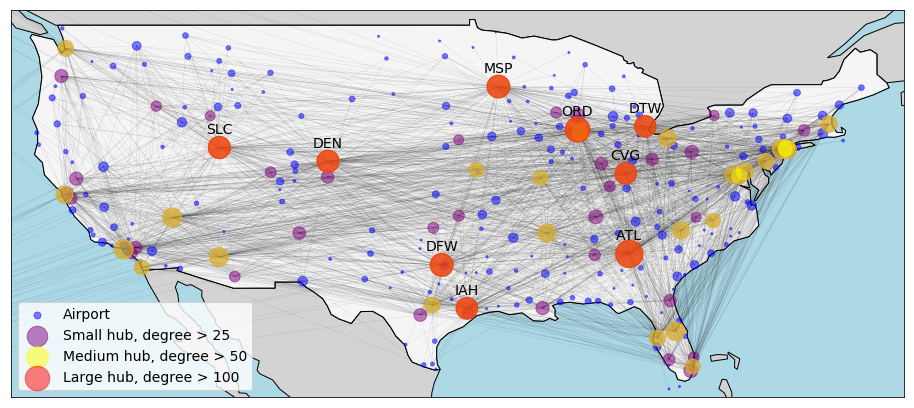

In [17]:
G7 = US_graph(FlightsNx07, Airports, scalar=4, alpha=.5)

G7.draw(path='Figures/map_general_07.png')

In [7]:
G18 = US_graph(FlightsNx18, Airports, scalar=4, alpha=.5)

G18.draw(path='Figures/map_general_18.png')

Name: 
Type: Graph
Number of nodes: 358
Number of edges: 3220
Average degree:  17.9888


KeyError: "['origin_degree_unn'] not in index"